<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />


<h1>Linear regression: Checkpoints</h1>


<h2>Table of Contents</h2>
<p>Model checkpoints are used for resuming training,but you must save more than just the model’s <code>state_dict</code>. It is important to also save the optimizer’s <code>state_dict</code>. In this lab we will save multiple components, organize them in a dictionary and use <code>torch.save()</code> to serialize the dictionary. We will then load the model resume training.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#LR_Loader_Cost">Create a Linear Regression Object, Data Loader and Criterion Function</a></li>
    <li><a href="#Stop"> Train the Model and Save Checkpoints  </a></li>
    <li><a href="#Result">Resume training model with Checkpoints </a></li>
</ul>

<p>Estimated Time Needed: <strong>15 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries, and set the random seed.


In [1]:
# Import the libraries and set random seed

from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

<!--Empty Space for separating topics-->


<h2 id="#Makeup_Data">Make Some Data</h2>


First let's create some artificial data, in a dataset class. 


In [2]:
# Create Data Class

class Data(Dataset):
    
    # Constructor
    def __init__(self, train = True):
        if train == True:
            self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
            self.f = -3 * self.x + 1
            self.y = self.f + 0.1 * torch.randn(self.x.size())
            self.len = self.x.shape[0]

            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

We create  a training data  object:


In [3]:
#Create train_data object and val_data object
train_data = Data()

We overlay the training points in red over the function that generated the data. 


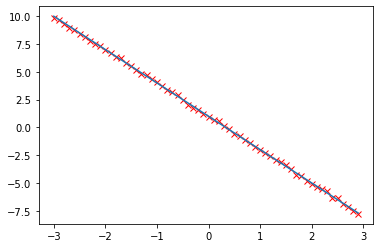

In [4]:
# Plot the training data points
plt.plot(train_data.x.numpy(), train_data.y.numpy(), 'xr')
plt.plot(train_data.x.numpy(), train_data.f.numpy())
plt.show()

<!--Empty Space for separating topics-->


<h2 id="LR_Loader_Cost">Create a Linear Regression Class, Object, Data Loader, Criterion Function</h2>


Create linear regression model class.


In [5]:
# Create linear regression model class

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # Predition
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

Create the model object 


In [6]:
# Create the model object

model = linear_regression(1, 1)

We create the optimizer, the criterion function and a Data Loader object.


In [7]:
# Create optimizer, cost function and data loader object

optimizer = optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)

<!--Empty Space for separating topics-->


<h2 id="Stop">Train the Model and Save Checkpoints </h2>


path to checkpoint and file name


In [8]:
checkpoint_path='checkpoint_model.pt'

checkpoint dictionary 


In [9]:
checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None}

Train for three epochs, save checkpoint information. The epoch, model state dictionary, optimizer state dictionary and loss are stored in a python dictionary. 


In [10]:

epochs=10
LOSS_TRAIN = []
for epoch in range(epochs):
    for x, y in trainloader:
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train = criterion(model(train_data.x), train_data.y).item()

        LOSS_TRAIN.append(loss_train)
    
    checkpoint['epoch']=epoch
    checkpoint['model_state_dict']=model.state_dict()
    checkpoint['optimizer_state_dict']= optimizer.state_dict()
    checkpoint['loss']=loss 
    torch.save(checkpoint, checkpoint_path)
    

<h2 id="Result">Resume training model with Checkpoints </h2>


We can load the checkpoint dictionary, using <code>torch load</code>


In [11]:
checkpoint = torch.load(checkpoint_path)
checkpoint

{'epoch': 9,
 'model_state_dict': OrderedDict([('linear.weight', tensor([[-3.0068]])),
              ('linear.bias', tensor([0.9827]))]),
 'optimizer_state_dict': {'state': {0: {'momentum_buffer': None},
   1: {'momentum_buffer': None}},
  'param_groups': [{'lr': 0.01,
    'momentum': 0,
    'dampening': 0,
    'weight_decay': 0,
    'nesterov': False,
    'params': [0, 1]}]},
 'loss': tensor(0.0032, requires_grad=True)}

We create a new model with arbitrary model parameter values :


In [12]:
model_checkpoint = linear_regression(1,1)
model_checkpoint.state_dict()

OrderedDict([('linear.weight', tensor([[-0.4254]])),
             ('linear.bias', tensor([-0.3027]))])

We load the state dictionary from the checkpoint dictionary into the model .


In [13]:
model_checkpoint.load_state_dict(checkpoint['model_state_dict'])
model_checkpoint.state_dict()

OrderedDict([('linear.weight', tensor([[-3.0068]])),
             ('linear.bias', tensor([0.9827]))])

we create an arbitrary optimizer object 


In [14]:
optimizer = optim.SGD(model_checkpoint.parameters(), lr = 1)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [0, 1]}]}

we can update the optimizer object using the optimizer state dictionary from the checkpoints:


In [15]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [0, 1]}]}

we  load the loss


In [16]:
loss =checkpoint['loss']
print('loss:',loss)

loss: tensor(0.0032, requires_grad=True)


we continue training the model 


In [17]:
for epoch in range(checkpoint['epoch'],epochs):
    for x, y in trainloader:
        yhat = model_checkpoint(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train = criterion(model_checkpoint(train_data.x), train_data.y).item()

        LOSS_TRAIN.append(loss_train)

<!--Empty Space for separating topics-->


View the  loss for every iteration on the training set


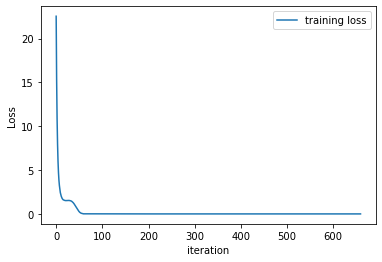

In [18]:
# Plot the loss

plt.plot(LOSS_TRAIN, label = 'training loss')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(loc = 'upper right')
plt.show()

We can see the model obtained via  early stopping fits the data points much better. For more variations of early stopping see:


Prechelt, Lutz.<i> "Early stopping-but when?." Neural Networks: Tricks of the trade. Springer, Berlin, Heidelberg, 1998. 55-69</i>.


 Inference


<!--Empty Space for separating topics-->


<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


<hr>


Copyright © 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.
